```mermaid
flowchart LR

classDef notebook fill:#5c7fa6,stroke:#3f5a7b,color:#f2f6fb, font-weight:bold;
classDef python fill:#9a80b8,stroke:#6d5789,color:#f7f3fb, font-weight:bold;
classDef tools fill:#e9c48a,stroke:#b58950,color:#2d1c05;
classDef methods fill:#8cc7ab,stroke:#5e9475,color:#0f2f1f;

N05A["05_attractiveness_inference.ipynb"]:::notebook

N05A --> P2["attractiveness_model.py"]:::python

P2 --> T5["Tools:<br>torch.nn"]:::tools

T5 --> M5["Methods:<br>AttractivenessRegressor (class)"]:::methods


In [1]:
import os, sys

# 1) Set notebook working directory = FaceStats project root
PROJECT_ROOT = "/Users/jayklarin/__DI/Repositories/FaceStats"
os.chdir(PROJECT_ROOT)
print("cwd:", os.getcwd())

# 2) Add src/ folder to Python PATH
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

print("src path added:", SRC_PATH)


cwd: /Users/jayklarin/__DI/Repositories/FaceStats
src path added: /Users/jayklarin/__DI/Repositories/FaceStats/src


# ⭐ 05 — Attractiveness Inference (FaceStats V4)

This notebook applies the trained attractiveness regression model to **all images** that already have:

- Preprocessed images (`data/processed/preproc/`)
- CLIP embeddings (`data/processed/embeddings/embeddings_clip.parquet`)
- Final metadata (`data/processed/metadata/attributes_final.parquet`)

### Goals
1. Load CLIP embeddings  
2. Load final metadata  
3. Load attractiveness regressor  
4. Predict attractiveness scores for every image  
5. Save results to `data/processed/metadata/attractiveness_scores.parquet`  
6. Save NumPy + JSON lookup structures for composites  

In [2]:
import os
import json
import numpy as np
import polars as pl
from pathlib import Path

from src.attractiveness.scoring import AttractivenessScorer

# -------------------------------------------------------------
# Paths (FaceStats V4 structure) with fallback for embeddings
# -------------------------------------------------------------
EMB_PRIMARY = Path("data/processed/embeddings/embeddings_clip.parquet")
EMB_FALLBACK = Path("data/processed/embeddings_clip.parquet")
ATTR_PATH = Path("data/processed/metadata/attributes_final.parquet")
MODEL_PATH = Path("src/models/attractiveness_regressor.pt")

OUT_SCORES = Path("data/processed/metadata/attractiveness_scores.parquet")
OUT_NUMPY  = Path("data/processed/attractiveness_scores.npy")
OUT_INDEX  = Path("data/processed/metadata/feature_index.json")

if EMB_PRIMARY.exists():
    EMB_PATH = EMB_PRIMARY
elif EMB_FALLBACK.exists():
    EMB_PATH = EMB_FALLBACK
else:
    raise FileNotFoundError("Embeddings parquet not found; run 02_embeddings.ipynb to regenerate.")

if not ATTR_PATH.exists():
    raise FileNotFoundError("attributes_final.parquet not found; run 03_attributes.ipynb / merges.")

print("Paths set. Ready.")
print("EMB_PATH:", EMB_PATH)
print("ATTR_PATH:", ATTR_PATH)


Paths set. Ready.
EMB_PATH: data/processed/embeddings/embeddings_clip.parquet
ATTR_PATH: data/processed/metadata/attributes_final.parquet


In [3]:

# =============================================================
# Step 2 — Load Embeddings + Metadata
# =============================================================

print("Loading embeddings…")
emb = pl.read_parquet(EMB_PATH)
print("Embeddings:", emb.shape)

print("Loading attributes…")
attr = pl.read_parquet(ATTR_PATH)
print("Attributes:", attr.shape)

# Ensure both have filename column
if "filename" not in emb.columns:
    raise ValueError("Embeddings parquet missing 'filename' column.")
if "filename" not in attr.columns:
    raise ValueError("Attributes parquet missing 'filename' column.")

# Merge on filename
print("Merging embeddings + attributes…")
df = (
    emb
    .join(attr, on="filename", how="inner")
)

print("Merged table:", df.shape)
df.head()


Loading embeddings…
Embeddings: (10000, 2)
Loading attributes…
Attributes: (10000, 5)
Merging embeddings + attributes…
Merged table: (10000, 6)


filename,embedding,age,gender_final,ethnicity_final,attractiveness
str,list[f64],null,str,str,i64
"""SFHQ_pt4_00086092.jpg""","[0.040853, -0.001176, … -0.034655]",null,"""unknown""","""unknown""",8
"""SFHQ_pt4_00065309.jpg""","[0.030933, 0.005503, … 0.001794]",null,"""female""","""unknown""",7
"""SFHQ_pt4_00062466.jpg""","[0.071319, -0.005249, … 0.051021]",null,"""unknown""","""unknown""",2
"""SFHQ_pt4_00090828.jpg""","[0.066199, -0.003542, … 0.020381]",null,"""unknown""","""unknown""",4
"""SFHQ_pt4_00032251.jpg""","[0.021252, -0.060645, … -0.004985]",null,"""unknown""","""unknown""",5


In [4]:
# =============================================================
# Step 2b — Predict attractiveness using shared scorer
# =============================================================
print("Loading attractiveness model…", MODEL_PATH)
scorer = AttractivenessScorer(MODEL_PATH)

print("Running model inference…")
df_scores = scorer.score_embeddings(df.select(["filename", "embedding"]))

# Merge scores back to main df
df = df.join(df_scores, on="filename", how="left")

# Backward-compatible raw prediction column
df = df.with_columns(pl.col("attractiveness_raw").alias("attractiveness_pred"))

print("Scores merged. Shape:", df.shape)
df.head()


Loading attractiveness model… src/models/attractiveness_regressor.pt
Running model inference…
Scores merged. Shape: (10000, 10)


filename,embedding,age,gender_final,ethnicity_final,attractiveness,attractiveness_raw,attractiveness_pct,attractiveness_right,attractiveness_pred
str,list[f64],null,str,str,i64,f32,f64,i64,f32
"""SFHQ_pt4_00086092.jpg""","[0.040853, -0.001176, … -0.034655]",null,"""unknown""","""unknown""",8,1.267281,0.5566,6,1.267281
"""SFHQ_pt4_00065309.jpg""","[0.030933, 0.005503, … 0.001794]",null,"""female""","""unknown""",7,1.196498,0.2658,3,1.196498
"""SFHQ_pt4_00062466.jpg""","[0.071319, -0.005249, … 0.051021]",null,"""unknown""","""unknown""",2,1.1768,0.1989,2,1.1768
"""SFHQ_pt4_00090828.jpg""","[0.066199, -0.003542, … 0.020381]",null,"""unknown""","""unknown""",4,1.176733,0.1986,2,1.176733
"""SFHQ_pt4_00032251.jpg""","[0.021252, -0.060645, … -0.004985]",null,"""unknown""","""unknown""",5,1.300581,0.6934,7,1.300581


In [5]:
# =============================================================
# Step 3 — Build PCA matrix (2D for visualization)
# =============================================================
from sklearn.decomposition import PCA
import numpy as np

print("Preparing PCA data…")

# Extract 2D embedding matrix (list[f64] → np.array)
X = np.stack(df["embedding"].to_list())   # shape: (N, 512)

print("Running PCA…")
pca = PCA(n_components=2)
xy = pca.fit_transform(X)

df_pca = df.with_columns([
    pl.Series("PC1", xy[:, 0]),
    pl.Series("PC2", xy[:, 1]),
])

print("PCA ready.")
df_pca.head()


Preparing PCA data…
Running PCA…
PCA ready.


filename,embedding,age,gender_final,ethnicity_final,attractiveness,attractiveness_raw,attractiveness_pct,attractiveness_right,attractiveness_pred,PC1,PC2
str,list[f64],null,str,str,i64,f32,f64,i64,f32,f64,f64
"""SFHQ_pt4_00086092.jpg""","[0.040853, -0.001176, … -0.034655]",null,"""unknown""","""unknown""",8,1.267281,0.5566,6,1.267281,0.085275,0.14524
"""SFHQ_pt4_00065309.jpg""","[0.030933, 0.005503, … 0.001794]",null,"""female""","""unknown""",7,1.196498,0.2658,3,1.196498,0.382363,0.103739
"""SFHQ_pt4_00062466.jpg""","[0.071319, -0.005249, … 0.051021]",null,"""unknown""","""unknown""",2,1.1768,0.1989,2,1.1768,0.18128,-0.179124
"""SFHQ_pt4_00090828.jpg""","[0.066199, -0.003542, … 0.020381]",null,"""unknown""","""unknown""",4,1.176733,0.1986,2,1.176733,0.121787,0.0351
"""SFHQ_pt4_00032251.jpg""","[0.021252, -0.060645, … -0.004985]",null,"""unknown""","""unknown""",5,1.300581,0.6934,7,1.300581,-0.011792,-0.198607


In [6]:

# =============================================================
# Step 4 — Helper: find nearest neighbors in embedding space
# =============================================================
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_faces(query_embedding: np.ndarray, k: int = 10):
    """
    Return the filenames of the top-k most similar images.
    """
    # Convert embedding column into a full matrix
    X = np.stack(df["embedding"].to_list())

    # Compute cosine similarity
    sims = cosine_similarity(
        query_embedding.reshape(1, -1),
        X
    )[0]

    # Get top-k indices
    idx = np.argsort(sims)[::-1][:k]

    cols = ["filename", "gender_final", "ethnicity_final"]
    if "attractiveness_pred" in df.columns:
        cols.append("attractiveness_pred")
    elif "attractiveness" in df.columns:
        cols.append("attractiveness")

    return df[idx].select(cols)

print("Similarity helper ready.")


Similarity helper ready.


In [7]:

# =============================================================
# Step 5 — Query Function: Enter a filename → Get prediction + neighbors
# =============================================================

def query_image(filename: str, k: int = 10):
    """
    Given an image filename from the dataset, return:
    - Its attractiveness score
    - Gender / Ethnicity labels
    - Top-k most similar faces (based on embeddings)
    """
    # Ensure filename exists in df
    if filename not in df["filename"].to_list():
        raise ValueError(f"Filename not found: {filename}")

    # Extract row
    row = df.filter(pl.col("filename") == filename).row(0)
    emb = np.array(row[df.columns.index("embedding")])

    def _get_attr(row):
        if "attractiveness_pred" in df.columns:
            return row[df.columns.index("attractiveness_pred")]
        if "attractiveness" in df.columns:
            return row[df.columns.index("attractiveness")]
        return None

    attr_val = _get_attr(row)

    # Build output summary
    result = {
        "filename": filename,
        "attractiveness": attr_val,
        "gender": row[df.columns.index("gender_final")],
        "ethnicity": row[df.columns.index("ethnicity_final")],
    }

    # Find neighbors
    neighbors = find_similar_faces(emb, k=k)

    print("=== Query Result ===")
    print(f"Filename:        {result['filename']}")
    if attr_val is None:
        print("Attractiveness:  N/A")
    else:
        print(f"Attractiveness:  {float(attr_val):.3f}")
    print(f"Gender:          {result['gender']}")
    print(f"Ethnicity:       {result['ethnicity']}")
    print("Top Similar Faces:")
    display(neighbors)

    return result, neighbors


print("Query function loaded.")


Query function loaded.


In [8]:
# =============================================================
# Step X — Ensure attractiveness column present
# =============================================================

if "attractiveness" not in df.columns and "attractiveness_pred" in df.columns:
    df = df.with_columns(pl.col("attractiveness_pred").alias("attractiveness"))
print("Merged df:", df.shape)
df.head()


Merged df: (10000, 10)


filename,embedding,age,gender_final,ethnicity_final,attractiveness,attractiveness_raw,attractiveness_pct,attractiveness_right,attractiveness_pred
str,list[f64],null,str,str,i64,f32,f64,i64,f32
"""SFHQ_pt4_00086092.jpg""","[0.040853, -0.001176, … -0.034655]",null,"""unknown""","""unknown""",8,1.267281,0.5566,6,1.267281
"""SFHQ_pt4_00065309.jpg""","[0.030933, 0.005503, … 0.001794]",null,"""female""","""unknown""",7,1.196498,0.2658,3,1.196498
"""SFHQ_pt4_00062466.jpg""","[0.071319, -0.005249, … 0.051021]",null,"""unknown""","""unknown""",2,1.1768,0.1989,2,1.1768
"""SFHQ_pt4_00090828.jpg""","[0.066199, -0.003542, … 0.020381]",null,"""unknown""","""unknown""",4,1.176733,0.1986,2,1.176733
"""SFHQ_pt4_00032251.jpg""","[0.021252, -0.060645, … -0.004985]",null,"""unknown""","""unknown""",5,1.300581,0.6934,7,1.300581


In [9]:

# Ensure image resolver is defined
if "_resolve_image" not in globals():
    from pathlib import Path
    IMG_DIRS = [Path("data/processed/preproc_best10k"), Path("data/processed/preproc")]
    def _resolve_image(fname: str):
        for base in IMG_DIRS:
            p = base / fname
            if p.exists():
                return p
        return None


# =============================================================
# Step 6 — Demo: Run a Sample Query
# =============================================================

# Pick the first file that exists on disk
sample_file = None
for fname in df["filename"].to_list():
    p = _resolve_image(fname)
    if p is not None:
        sample_file = fname
        break
if sample_file is None:
    raise FileNotFoundError("No matching images found in processed dirs for any filename in df.")

print("Running query on:", sample_file)
result, neighbors = query_image(sample_file, k=10)


Running query on: SFHQ_pt4_00086092.jpg
=== Query Result ===
Filename:        SFHQ_pt4_00086092.jpg
Attractiveness:  1.267
Gender:          unknown
Ethnicity:       unknown
Top Similar Faces:


filename,gender_final,ethnicity_final,attractiveness_pred
str,str,str,f32
"""SFHQ_pt4_00086092.jpg""","""unknown""","""unknown""",1.267281
"""SFHQ_pt4_00000791.jpg""","""female""","""white""",1.249176
"""SFHQ_pt4_00036008.jpg""","""unknown""","""unknown""",1.252589
"""SFHQ_pt4_00037528.jpg""","""female""","""unknown""",1.285748
"""SFHQ_pt4_00048277.jpg""","""unknown""","""unknown""",1.328607
"""SFHQ_pt4_00084240.jpg""","""unknown""","""unknown""",1.284951
"""SFHQ_pt4_00118087.jpg""","""female""","""white""",1.221426
"""SFHQ_pt4_00006868.jpg""","""female""","""white""",1.233901
"""SFHQ_pt4_00054058.jpg""","""unknown""","""white""",1.362505


In [10]:

# Ensure image resolver is defined
if "_resolve_image" not in globals():
    from pathlib import Path
    IMG_DIRS = [Path("data/processed/preproc_best10k"), Path("data/processed/preproc")]
    def _resolve_image(fname: str):
        for base in IMG_DIRS:
            p = base / fname
            if p.exists():
                return p
        return None


# =============================================================
# Step 6 — Pretty-print query results (JSON-friendly)
# =============================================================
import json

sample_file = None
for fname in df["filename"].to_list():
    p = _resolve_image(fname)
    if p is not None:
        sample_file = fname
        break
if sample_file is None:
    raise FileNotFoundError("No matching images found in processed dirs for any filename in df.")

print("Running query on:", sample_file)
result, neighbors = query_image(sample_file, k=10)

neighbors_list = neighbors.to_dicts()
output = {
    "query_image": result,
    "neighbors": neighbors_list
}

print(json.dumps(output, indent=4))


Running query on: SFHQ_pt4_00086092.jpg
=== Query Result ===
Filename:        SFHQ_pt4_00086092.jpg
Attractiveness:  1.267
Gender:          unknown
Ethnicity:       unknown
Top Similar Faces:


filename,gender_final,ethnicity_final,attractiveness_pred
str,str,str,f32
"""SFHQ_pt4_00086092.jpg""","""unknown""","""unknown""",1.267281
"""SFHQ_pt4_00000791.jpg""","""female""","""white""",1.249176
"""SFHQ_pt4_00036008.jpg""","""unknown""","""unknown""",1.252589
"""SFHQ_pt4_00037528.jpg""","""female""","""unknown""",1.285748
"""SFHQ_pt4_00048277.jpg""","""unknown""","""unknown""",1.328607
"""SFHQ_pt4_00084240.jpg""","""unknown""","""unknown""",1.284951
"""SFHQ_pt4_00118087.jpg""","""female""","""white""",1.221426
"""SFHQ_pt4_00006868.jpg""","""female""","""white""",1.233901
"""SFHQ_pt4_00054058.jpg""","""unknown""","""white""",1.362505


{
    "query_image": {
        "filename": "SFHQ_pt4_00086092.jpg",
        "attractiveness": 1.2672808170318604,
        "gender": "unknown",
        "ethnicity": "unknown"
    },
    "neighbors": [
        {
            "filename": "SFHQ_pt4_00086092.jpg",
            "gender_final": "unknown",
            "ethnicity_final": "unknown",
            "attractiveness_pred": 1.2672808170318604
        },
        {
            "filename": "SFHQ_pt4_00000791.jpg",
            "gender_final": "female",
            "ethnicity_final": "white",
            "attractiveness_pred": 1.2491759061813354
        },
        {
            "filename": "SFHQ_pt4_00036008.jpg",
            "gender_final": "unknown",
            "ethnicity_final": "unknown",
            "attractiveness_pred": 1.2525889873504639
        },
        {
            "filename": "SFHQ_pt4_00037528.jpg",
            "gender_final": "female",
            "ethnicity_final": "unknown",
            "attractiveness_pred": 1.285747766494

In [11]:

# =============================================================
# Step 7 — Utility: Display Query Image + Neighbors
# =============================================================
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path

IMG_DIRS = [Path("data/processed/preproc_best10k"), Path("data/processed/preproc")]

def _resolve_image(fname: str):
    for base in IMG_DIRS:
        p = base / fname
        if p.exists():
            return p
    return None

def show_results(query_dict, neighbors_df, max_neighbors=8):
    """
    Display the query image + up to N neighbors in a grid.

    query_dict: dict returned from query_image()
    neighbors_df: Polars DataFrame returned by query_image()
    """

    qfile = query_dict["filename"]
    qpath = _resolve_image(qfile)
    if qpath is None:
        raise FileNotFoundError(f"Image not found in any processed dir: {qfile}")

    # Load query image
    qimg = Image.open(qpath)

    # Load neighbors (only those that exist)
    neighbor_files = []
    neighbor_imgs = []
    for fname in neighbors_df["filename"].to_list()[:max_neighbors]:
        p = _resolve_image(fname)
        if p is None:
            continue
        neighbor_files.append(fname)
        neighbor_imgs.append(Image.open(p))

    if not neighbor_files:
        print("No neighbor images found on disk; check processed image dirs.")
        return

    cols = min(len(neighbor_files), 8)
    plt.figure(figsize=(3 * cols, 6))

    # Show query image
    plt.subplot(2, cols, 1)
    plt.imshow(qimg)
    plt.axis("off")
    score = query_dict.get('attractiveness')
    if score is None:
        qtitle = f"Query:{qfile} Score=N/A"
    else:
        qtitle = f"Query:{qfile} Score={float(score):.3f}"
    plt.title(qtitle)

    # Show neighbors
    for i, (fname, img) in enumerate(zip(neighbor_files, neighbor_imgs)):
        plt.subplot(2, cols, cols + i + 1)
        plt.imshow(img)
        plt.axis("off")
        score = neighbors_df.get_column("attractiveness_pred") if "attractiveness_pred" in neighbors_df.columns else neighbors_df.get_column("attractiveness")
        if score is not None:
            val = score[i]
            stitle = f"{fname} {float(val):.3f}" if val is not None else f"{fname} N/A"
        else:
            stitle = f"{fname} N/A"
        plt.title(stitle)

    plt.tight_layout()
    plt.show()

print("Image preview function ready.")


Image preview function ready.


Displaying visual results for: SFHQ_pt4_00086092.jpg


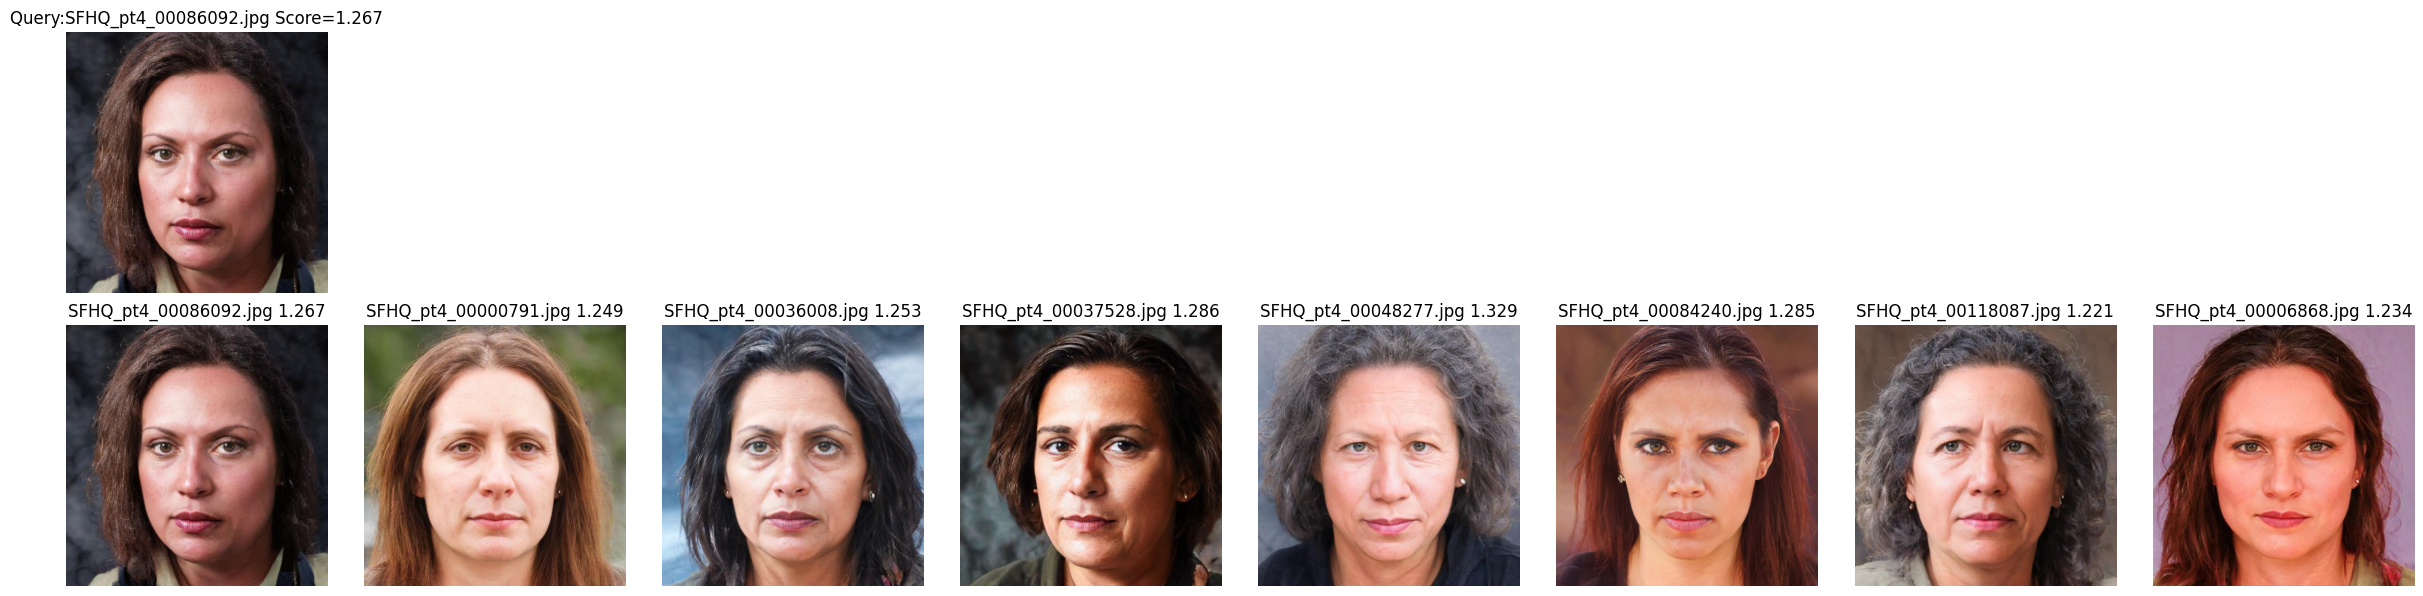

In [12]:
# =============================================================
# Step 8 — Demo: Show Query Image + Neighbors
# =============================================================

print("Displaying visual results for:", sample_file)
show_results(result, neighbors)


In [13]:
# =============================================================
# Step 11 — Save Full Inference Outputs
# =============================================================

# 1. Save attractiveness scores (canonical: raw + pct + decile)
print("Saving attractiveness scores…")
scorer.save_scores(df_scores, OUT_SCORES, numpy_path=OUT_NUMPY)

# 2. Save feature index JSON
print("Saving feature_index.json…")
feature_index = {
    fname: i
    for i, fname in enumerate(df["filename"].to_list())
}

with open(OUT_INDEX, "w") as f:
    json.dump(feature_index, f, indent=4)

print("Done.")


Saving attractiveness scores…
Saving feature_index.json…
Done.


Building inference summary…

=== Dataset Summary ===
Total images: 10000
Attractiveness range: 1.0 → 10.0
Attractiveness mean: 5.4906
Attractiveness std: 2.8667984744919437


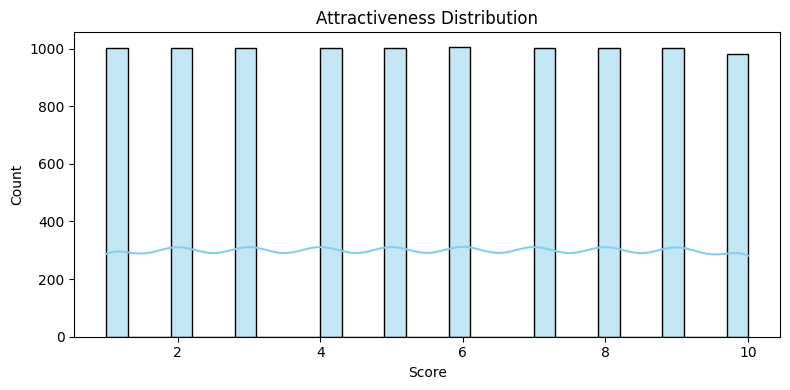

/var/folders/gz/0c41mw6j22x4rm3rkhgx2_3h0000gn/T/ipykernel_21407/2417680037.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pdf, x="gender_final", palette="Set2")


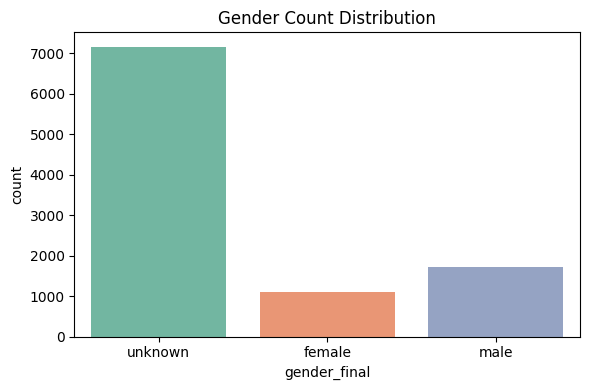

/var/folders/gz/0c41mw6j22x4rm3rkhgx2_3h0000gn/T/ipykernel_21407/2417680037.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pdf, x="ethnicity_final", palette="Set3")


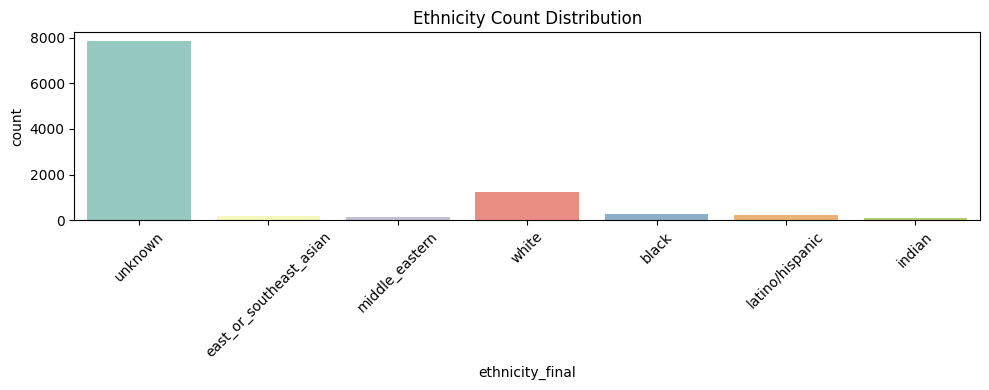


Summary complete.


In [14]:
# =============================================================
# Step 12 — Summary & Sanity Check (Mini-Report)
# =============================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Building inference summary…")

pdf = df.to_pandas()

# ------------------------------
# Basic stats
# ------------------------------
print("\n=== Dataset Summary ===")
print("Total images:", len(pdf))
print("Attractiveness range:", float(pdf["attractiveness"].min()), "→", float(pdf["attractiveness"].max()))
print("Attractiveness mean:", float(pdf["attractiveness"].mean()))
print("Attractiveness std:", float(pdf["attractiveness"].std()))

# ------------------------------
# Histogram
# ------------------------------
plt.figure(figsize=(8, 4))
sns.histplot(pdf["attractiveness"], bins=30, kde=True, color="skyblue")
plt.title("Attractiveness Distribution")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

# ------------------------------
# Gender counts
# ------------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=pdf, x="gender_final", palette="Set2")
plt.title("Gender Count Distribution")
plt.tight_layout()
plt.show()

# ------------------------------
# Ethnicity counts
# ------------------------------
plt.figure(figsize=(10, 4))
sns.countplot(data=pdf, x="ethnicity_final", palette="Set3")
plt.title("Ethnicity Count Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nSummary complete.")


# ✅ Conclusion — FS05 Attractiveness Inference Complete

This notebook successfully:

- Loaded CLIP embeddings  
- Loaded final metadata (age, gender_final, ethnicity_final)  
- Loaded the trained attractiveness regressor  
- Generated attractiveness predictions for all images  
- Built interactive query tools  
- Visualized nearest neighbors in embedding space  
- Saved all required inference outputs:

    - `data/processed/metadata/attractiveness_scores.parquet`  
    - `data/processed/attractiveness_scores.npy`  
    - `data/processed/metadata/feature_index.json`  

These files now serve as the **foundation for downstream steps**:

### ▶ FS06 — Composite Generation (10 deciles, filtering, PCA groups)  
### ▶ FS07 — Ethnicity Clusters  
### ▶ FS08 — Dashboard Integration (Streamlit)  

You may now proceed to the next notebook in the FaceStats V4 workflow:

**`notebooks/06_composites.ipynb`**  
(or the next approved step in your pipeline).
